## Оптимизация выполнения кода, векторизация, Numba

Материалы:
* Макрушин С.В. Лекция 3: Оптимизация выполнения кода, векторизация, Numba
* IPython Cookbook, Second Edition (2018), глава 4
* https://numba.pydata.org/numba-doc/latest/user/5minguide.html

In [117]:
import random
import numpy as np
import pandas as pd
import string
import timeit
import numba

## Задачи для совместного разбора

1. Сгенерируйте массив `A` из `N=1млн` случайных целых чисел на отрезке от 0 до 1000. Пусть `B[i] = A[i] + 100`. Посчитайте среднее значение массива `B`.

In [105]:
N = 1000000
A = np.random.randint(0, 1000, size=N)
B = A + 100

B_average = sum(B) / N
print("Среднее значение массива B:", B_average)

Среднее значение массива B: 599.485045


2. Создайте таблицу 2млн строк и с 4 столбцами, заполненными случайными числами. Добавьте столбец `key`, которые содержит элементы из множества английских букв. Выберите из таблицы подмножество строк, для которых в столбце `key` указаны первые 5 английских букв.

In [106]:
df = pd.DataFrame(np.random.randn(2000000, 4), columns=list('ABCD'))

# добавляем столбец key в DataFrame
df['key'] = pd.Series(list(string.ascii_lowercase)*2000000)

# выбираем нужные строки
res = df[df['key'].str[:].isin(['a', 'b', 'c', 'd', 'e'])]

res

,A,B,C,D,key
0,0.139111,-0.674916,-2.090669,0.201839,a
1,0.720438,1.739228,-0.861801,-0.256902,b
2,0.100917,-0.509725,-1.516989,0.362609,c
3,1.290043,0.329973,0.904139,-0.032878,d
4,0.533161,-0.911284,-0.346263,0.290808,e
...,...,...,...,...,...
1999974,-0.415615,-0.135450,0.223522,-0.562608,c
1999975,-0.306035,-0.837046,-1.447010,1.502363,d
1999976,-0.915597,-1.547143,-2.351006,-0.372183,e
1999998,0.469577,-0.464978,0.775665,1.366447,a


## Лабораторная работа 3

1. В файлах `recipes_sample.csv` и `reviews_sample.csv` (__ЛР 2__) находится информация об рецептах блюд и отзывах на эти рецепты соответственно. Загрузите данные из файлов в виде `pd.DataFrame` с названиями `recipes` и `reviews`. Обратите внимание на корректное считывание столбца(ов) с индексами. Приведите столбцы к нужным типам.

Реализуйте несколько вариантов функции подсчета среднего значения столбца `rating` из таблицы `reviews` для отзывов, оставленных в 2010 году.

A. С использованием метода `DataFrame.iterrows` исходной таблицы;

Б. С использованием метода `DataFrame.iterrows` таблицы, в которой сохранены только отзывы за 2010 год;

В. С использованием метода `Series.mean`.

Проверьте, что результаты работы всех написанных функций корректны и совпадают. Измерьте выполнения всех написанных функций.


In [198]:
recipes = pd.read_csv("recipes_sample.csv")
reviews = pd.read_csv('reviews_sample.csv')
recipes['submitted'] = recipes['submitted'].astype("datetime64[ns]")
reviews['date'] = reviews['date'].astype("datetime64[ns]")
reviews

,Unnamed: 0,user_id,recipe_id,date,rating,review
0,370476,21752,57993,2003-05-01,5,Last week whole sides of frozen salmon fillet ...
1,624300,431813,142201,2007-09-16,5,So simple and so tasty! I used a yellow capsi...
2,187037,400708,252013,2008-01-10,4,"Very nice breakfast HH, easy to make and yummy..."
3,706134,2001852463,404716,2017-12-11,5,These are a favorite for the holidays and so e...
4,312179,95810,129396,2008-03-14,5,Excellent soup! The tomato flavor is just gre...
...,...,...,...,...,...,...
126691,1013457,1270706,335534,2009-05-17,4,This recipe was great! I made it last night. I...
126692,158736,2282344,8701,2012-06-03,0,This recipe is outstanding. I followed the rec...
126693,1059834,689540,222001,2008-04-08,5,"Well, we were not a crowd but it was a fabulou..."
126694,453285,2000242659,354979,2015-06-02,5,I have been a steak eater and dedicated BBQ gr...


In [230]:
def A(df):
    total_rating = 0
    num_reviews = 0
    for index, row in df.iterrows():
        if row['date'].year == 2010:
            total_rating += row['rating']
            num_reviews += 1
    mean_rating = total_rating / num_reviews
    return mean_rating

In [231]:
%%time
A(reviews)

CPU times: total: 8.94 s
Wall time: 8.94 s


4.4544402182900615

In [242]:
def B(df):
    reviews_2010 = df[reviews['date'].dt.year == 2010]
    total_rating = 0
    num_reviews = 0
    for index, row in reviews_2010.iterrows():
        total_rating += row['rating']
        num_reviews += 1
    mean_rating = total_rating / num_reviews
    return mean_rating

In [244]:
%%time
B(reviews)

CPU times: total: 812 ms
Wall time: 816 ms


4.4544402182900615

In [245]:
def C(df):
    reviews_2010 = df[reviews['date'].dt.year == 2010]
    mean_rating = reviews_2010['rating'].mean()
    return mean_rating

In [247]:
%%time
C(reviews)

CPU times: total: 15.6 ms
Wall time: 18.8 ms


4.4544402182900615

2. Какая из созданных функций выполняется медленнее? Что наиболее сильно влияет на скорость выполнения? Для ответа использовать профайлер `line_profiler`. Сохраните результаты работы профайлера в отдельную текстовую ячейку и прокомментируйте результаты его работы.

(*). Сможете ли вы ускорить работу функции 1Б, отказавшись от использования метода `iterrows`, но не используя метод `mean`?

In [219]:
!pip install line_profiler
%load_ext line_profiler
from line_profiler import LineProfiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [248]:
%lprun -f A A(reviews) 

Timer unit: 1e-07 s

Total time: 32.766 s
File: C:\Users\eliza\AppData\Local\Temp\ipykernel_25536\1115547370.py
Function: A at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     1                                           def A(df):
     2         1         15.0     15.0      0.0      total_rating = 0
     3         1          8.0      8.0      0.0      num_reviews = 0
     4    126696  274783792.0   2168.8     83.9      for index, row in df.iterrows():
     5    114602   48350371.0    421.9     14.8          if row['date'].year == 2010:
     6     12094    4411054.0    364.7      1.3              total_rating += row['rating']
     7     12094     114909.0      9.5      0.0              num_reviews += 1
     8         1         17.0     17.0      0.0      mean_rating = total_rating / num_reviews
     9         1          7.0      7.0      0.0      return mean_rating

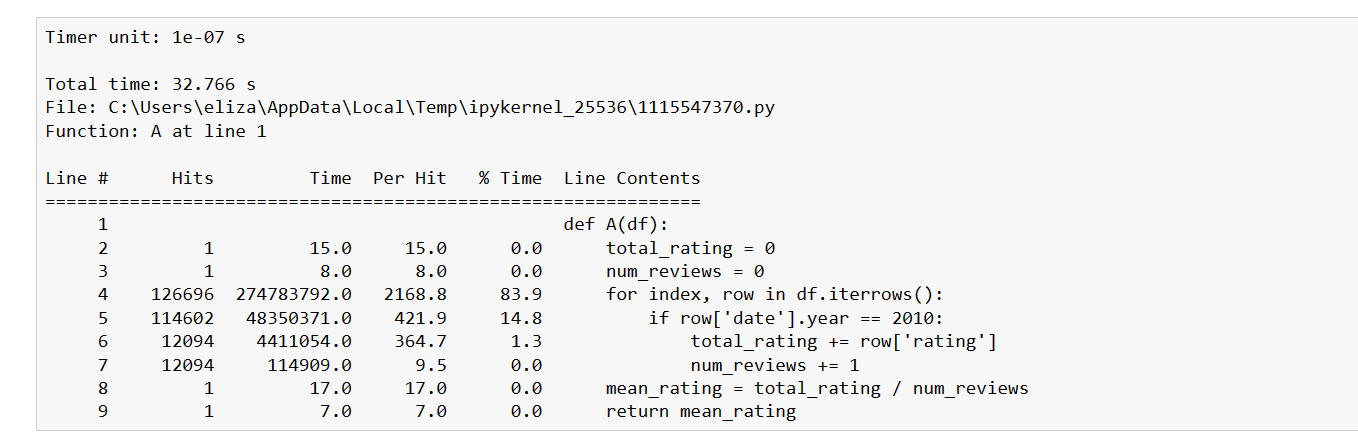

In [249]:
%lprun -f B B(reviews) 

Timer unit: 1e-07 s

Total time: 3.12221 s
File: C:\Users\eliza\AppData\Local\Temp\ipykernel_25536\1358884043.py
Function: B at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     1                                           def B(df):
     2         1     454205.0 454205.0      1.5      reviews_2010 = df[reviews['date'].dt.year == 2010]
     3         1          8.0      8.0      0.0      total_rating = 0
     4         1          5.0      5.0      0.0      num_reviews = 0
     5     12094   25627246.0   2119.0     82.1      for index, row in reviews_2010.iterrows():
     6     12094    5032583.0    416.1     16.1          total_rating += row['rating']
     7     12094     108076.0      8.9      0.3          num_reviews += 1
     8         1         12.0     12.0      0.0      mean_rating = total_rating / num_reviews
     9         1          4.0      4.0      0.0      return mean_rating

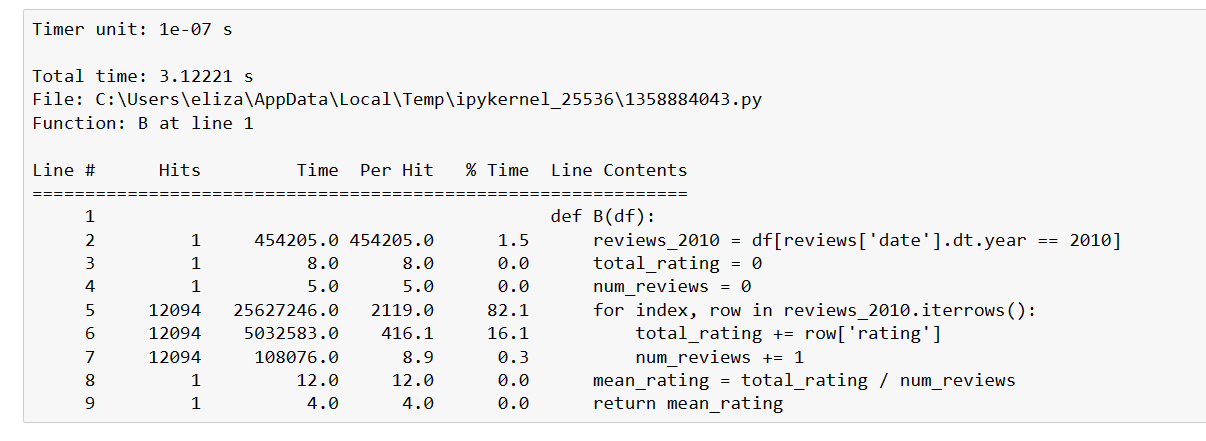

In [250]:
%lprun -f C C(reviews)

Timer unit: 1e-07 s

Total time: 0.0214808 s
File: C:\Users\eliza\AppData\Local\Temp\ipykernel_25536\193603030.py
Function: C at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     1                                           def C(df):
     2         1     208034.0 208034.0     96.8      reviews_2010 = df[reviews['date'].dt.year == 2010]
     3         1       6767.0   6767.0      3.2      mean_rating = reviews_2010['rating'].mean()
     4         1          7.0      7.0      0.0      return mean_rating

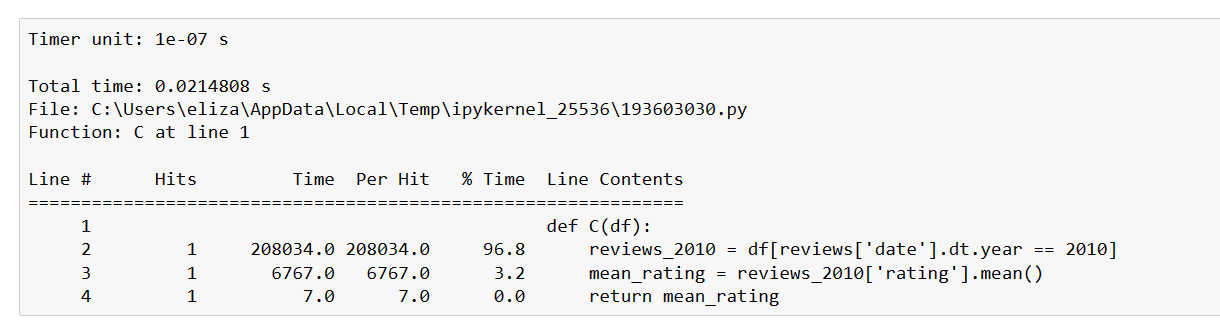

**Оптимизация функции 1Б:**

In [252]:
def B1(df):
    df=df[df['date'].dt.year==2010]
    return df['rating'].sum()/df.shape[0]

In [255]:
%%time
B1(reviews)

CPU times: total: 15.6 ms
Wall time: 19.1 ms


4.4544402182900615

3. Вам предлагается воспользоваться функцией, которая собирает статистику о том, сколько отзывов содержат то или иное слово. Измерьте время выполнения этой функции. Сможете ли вы найти узкие места в коде, используя профайлер? Выпишите (словами), что в имеющемся коде реализовано неоптимально. Оптимизируйте функцию и добейтесь значительного (как минимум, на один порядок) прироста в скорости выполнения.

In [76]:
def get_word_reviews_count(df):
    word_reviews = {}
    for _, row in df.dropna(subset=['review']).iterrows():
        recipe_id, review = row['recipe_id'], row['review']
        words = review.split(' ')
        for word in words:
            if word not in word_reviews:
                word_reviews[word] = []
            word_reviews[word].append(recipe_id)
    
    word_reviews_count = {}
    for _, row in df.dropna(subset=['review']).iterrows():
        review = row['review']
        words = review.split(' ')
        for word in words:
            word_reviews_count[word] = len(word_reviews[word])
    return word_reviews_count

In [77]:
time = timeit.timeit(lambda: get_word_reviews_count(reviews), number=1)
print(f"Time: {time}")

Time: 29.732451500000025


In [78]:
%%time
get_word_reviews_count(reviews)

CPU times: total: 29.9 s
Wall time: 29.9 s


{'Last': 94,
 'week': 804,
 'whole': 5628,
 'sides': 312,
 'of': 109029,
 'frozen': 2647,
 'salmon': 729,
 'fillet': 60,
 'was': 88781,
 'on': 34583,
 'sale': 149,
 'in': 61539,
 'my': 44144,
 'local': 561,
 'supermarket,': 10,
 'so': 46090,
 'I': 285147,
 'bought': 1369,
 'tons': 161,
 '(okay,': 5,
 'only': 13965,
 '3,': 48,
 'but': 42513,
 'total': 381,
 'weight': 160,
 'over': 9065,
 '10': 2303,
 'pounds).': 2,
 '': 214145,
 'This': 39448,
 'recipe': 41098,
 'is': 55075,
 'perfect': 4398,
 'for': 121224,
 'fillet,': 14,
 'even': 7878,
 'though': 2314,
 'it': 111175,
 'calls': 520,
 'steaks.': 93,
 'cut': 6688,
 'up': 13585,
 'the': 266050,
 'into': 7031,
 'individual': 314,
 'portions': 156,
 'and': 217849,
 'followed': 4859,
 'instructions': 731,
 'exactly.': 571,
 "I'm": 7145,
 'one': 15086,
 'those': 2287,
 'food': 2413,
 'combining': 74,
 'diets,': 5,
 'left': 4690,
 'out': 23644,
 'white': 3425,
 'wine': 1256,
 'added': 21710,
 'just': 24944,
 'a': 166136,
 'dash': 532,
 'vineg

Неоптимально реализованы:

1)использование циклов

2)проверка на наличие слова в словаре word_reviews при каждом проходе

3)создание новых списков и словарей вместо использования генераторов

In [79]:
#Оптимизированная функция
def get_word_reviews_count2(df):
    word_reviews = {}
    word_reviews_count = {}
    
    for _, row in df.dropna(subset=['review']).iterrows():
        recipe_id, review = row['recipe_id'], row['review']
        words = review.split(' ')
        
        for word in words:
            if word not in word_reviews:
                word_reviews[word] = []
            word_reviews[word].append(recipe_id)
            if word not in word_reviews_count:
                word_reviews_count[word] = 1
            else:
                word_reviews_count[word] += 1
                
    return word_reviews_count

In [80]:
%%time
get_word_reviews_count2(reviews)

CPU times: total: 18.4 s
Wall time: 18.4 s


{'Last': 94,
 'week': 804,
 'whole': 5628,
 'sides': 312,
 'of': 109029,
 'frozen': 2647,
 'salmon': 729,
 'fillet': 60,
 'was': 88781,
 'on': 34583,
 'sale': 149,
 'in': 61539,
 'my': 44144,
 'local': 561,
 'supermarket,': 10,
 'so': 46090,
 'I': 285147,
 'bought': 1369,
 'tons': 161,
 '(okay,': 5,
 'only': 13965,
 '3,': 48,
 'but': 42513,
 'total': 381,
 'weight': 160,
 'over': 9065,
 '10': 2303,
 'pounds).': 2,
 '': 214145,
 'This': 39448,
 'recipe': 41098,
 'is': 55075,
 'perfect': 4398,
 'for': 121224,
 'fillet,': 14,
 'even': 7878,
 'though': 2314,
 'it': 111175,
 'calls': 520,
 'steaks.': 93,
 'cut': 6688,
 'up': 13585,
 'the': 266050,
 'into': 7031,
 'individual': 314,
 'portions': 156,
 'and': 217849,
 'followed': 4859,
 'instructions': 731,
 'exactly.': 571,
 "I'm": 7145,
 'one': 15086,
 'those': 2287,
 'food': 2413,
 'combining': 74,
 'diets,': 5,
 'left': 4690,
 'out': 23644,
 'white': 3425,
 'wine': 1256,
 'added': 21710,
 'just': 24944,
 'a': 166136,
 'dash': 532,
 'vineg

Изменения, внесенные в функцию:
- убран цикл подсчета количества слов, который проходит по каждому слову в датафрейме. вместо этого, подсчет количества слов происходит в той же итерации, когда слово добавляется в словарь word_reviews.
- убраны повторяющиеся операции.
- словарь word_reviews_count теперь создается сразу при объявлении, при проверке в цикле, добавляется ли слово в word_reviews, оно сразу добавляется в word_reviews_count с количеством 1, чтобы не проверять наличие слова в этом словаре в каждом цикле.

4. Напишите несколько версий функции `MAPE` (см. [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error)) для расчета среднего абсолютного процентного отклонения значения рейтинга отзыва на рецепт от среднего значения рейтинга по всем отзывам для этого рецепта. 
    1. Без использования векторизованных операций и методов массивов `numpy` и без использования `numba`
    2. Без использования векторизованных операций и методов массивов `numpy`, но с использованием `numba`
    3. С использованием векторизованных операций и методов массивов `numpy`, но без использования `numba`
    4. C использованием векторизованных операций и методов массивов `numpy` и `numba`
    
Измерьте время выполнения каждой из реализаций.

Замечание: удалите из выборки отзывы с нулевым рейтингом.


In [164]:
#A. Без использования векторизованных операций и методов массивов numpy и без использования numba:
def mape_a(reviews):
    rating_sum = 0.0
    count = 0
    for r in reviews:
        if r != 0:
            rating_sum += r
            count += 1
    mean_rating = rating_sum / count
    abs_diff_sum = 0.0
    for r in reviews:
        if r != 0:
            abs_diff_sum += abs(r - mean_rating) / mean_rating
    return (abs_diff_sum / count) * 100

In [165]:
%%time
mape_a(reviews)

CPU times: total: 547 ms
Wall time: 560 ms


39.86261012569429

In [166]:
#B. Без использования векторизованных операций и методов массивов numpy, но с использованием numba:
@numba.jit(nopython=True)
def mape_b(reviews):
    rating_sum = 0.0
    count = 0
    for r in reviews:
        if r != 0:
            rating_sum += r
            count += 1
    mean_rating = rating_sum / count
    abs_diff_sum = 0.0
    for r in reviews:
        if r != 0:
            abs_diff_sum += abs(r - mean_rating) / mean_rating
    return (abs_diff_sum / count) * 100

In [167]:
%%time
mape_b(reviews)

CPU times: total: 281 ms
Wall time: 322 ms


39.86261012569429

In [168]:
#C. С использованием векторизованных операций и методов массивов numpy, но без использования numba:
def mape_c(reviews):
    reviews = np.array(reviews)
    reviews = reviews[reviews != 0]
    mean_rating = reviews.mean()
    abs_diff = np.abs(reviews - mean_rating) / mean_rating
    return abs_diff.mean() * 100

In [169]:
%%time
mape_c(reviews)

CPU times: total: 15.6 ms
Wall time: 4 ms


39.86261012571317

In [176]:
#D. С использованием векторизованных операций и методов массивов numpy и numba:
@numba.jit(nopython=True)
def mape_d(reviews):
    return np.mean(np.abs(reviews - np.mean(reviews)) / reviews) * 100

In [177]:
%%time
mape_d(reviews)

CPU times: total: 203 ms
Wall time: 207 ms


inf

#### [версия 2]
* Уточнены формулировки задач 1, 3, 4